In [34]:
import numpy as np
import cupy as cp
import pandas as pd
import time
import matplotlib.pyplot as plt
from itertools import combinations,product
from multiprocessing import Pool
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.datasets import load_digits, fetch_openml
from sklearn.model_selection import GridSearchCV
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
from qiskit.circuit import ParameterVector
import cuquantum

In [35]:
## First, get 1k MNIST data of only 2-type each. And  

mnist = fetch_openml('mnist_784')
X = mnist.data.to_numpy()
Y = mnist.target.to_numpy().astype(int)
class_list = [7,9]
c01 = np.where((Y == class_list[0])|(Y == class_list[1]))
X,Y = X[c01],Y[c01]
MAX=500
data_train, label_train = X[:MAX],Y[:MAX]
X_train, X_val, Y_train, Y_val = train_test_split(data_train, label_train, test_size = 0.2, random_state=255)

In [36]:
print('train & val shape:',X_train.shape, X_val.shape)
print('train class count:',len(Y_train[np.where(Y_train==class_list[0])]),len(Y_train[np.where(Y_train==class_list[1])]))
print('test  class count:',len(Y_val[np.where(Y_val==class_list[0])]),len(Y_val[np.where(Y_val==class_list[1])]))

train & val shape: (80, 784) (20, 784)
train class count: 39 41
test  class count: 9 11


In [37]:
nb1,nb2=10,5
def data_prepare(n_dim, sample_train, sample_test):
    std_scale = StandardScaler().fit(sample_train)
    data = std_scale.transform(sample_train)
    sample_train = std_scale.transform(sample_train)
    sample_test = std_scale.transform(sample_test)
    pca = PCA(n_components=n_dim, svd_solver="full").fit(data)
    sample_train = pca.transform(sample_train)
    sample_test = pca.transform(sample_test)
    samples = np.append(sample_train, sample_test, axis=0)
    minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
    sample_train = minmax_scale.transform(sample_train)[:nb1]
    sample_test = minmax_scale.transform(sample_test)[:nb2]
    return sample_train, sample_test
def svm_score(sample_train,labels_train,sample_val,labels_val):
    parameters = {'C':[1], 'gamma': [0.001, 0.1, 0.25, 0.5, 0.75, 1, 1.25, 2.5, 3.75, 5, 6.25, 7.5, 8.75, 10, 50, 100, 1000]}
    svc_grid_search = SVC(kernel="rbf")
    clf = GridSearchCV(svc_grid_search, param_grid=parameters, scoring='accuracy')
    clf.fit(sample_train,labels_train)
    result1=clf.score(sample_train,labels_train)
    result2=clf.score(sample_val,labels_val)
    return result1, result2

In [38]:
for q in [2]:
    n_dim = q
    data_train, data_val  = data_prepare(n_dim, X_train, X_val)
    score1, score2 = svm_score(data_train,Y_train[:nb1],data_val,Y_val[:nb2])
    print(n_dim,score1, score2)
#for q in [200,300,400,500,600,784]:
#    n_dim = q
#    data_train, data_val  = data_prepare(n_dim, X_train, X_val)
#    score1, score2 = svm_score(data_train,Y_train[:100],data_val,Y_val[:50])
#    print(n_dim,score1, score2)

/opt/conda/envs/cuquantum-24.03/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


2 0.9 0.6


## statevector simulation

In [39]:
def make_bsp(n_dim):
    param = ParameterVector("p",n_dim)
    bsp_qc = QuantumCircuit(n_dim)
    bsp_qc.h(list(range(n_dim)))
    i = 0
    for q in range(n_dim):
        bsp_qc.rz(param.params[q],[q])
        bsp_qc.ry(param.params[q],[q])
    for q in range(n_dim-1):
        bsp_qc.cx(0+i, 1+i)
        i+=1
    for q in range(n_dim):
        bsp_qc.rz(param.params[q],[q])
    return bsp_qc
def all_circuits_parallel(y_t, x_t, indices_list, n_dim, num_cpu):
    psix = make_bsp(n_dim)
    #psix = ZZFeatureMap(feature_dimension=n_dim, reps=1, entanglement="linear")
    psiy = psix.inverse()
    with Pool(processes=num_cpu, maxtasksperchild=100) as pool:
        circuits = [ psix.assign_parameters(x_t[i2-1]).compose(psiy.assign_parameters(y_t[i1-1])) for i1, i2 in indices_list ]        
        #circuits = pool.starmap(kernel.construct_circuit, [(y_t[i1-1], x_t[i2-1],False) for i1, i2 in indices_list])
    return circuits
def kernel_matrix_svsm(y_t, x_t, circuit,indices_list, simulator, mode=None):
    kernel_matrix = np.zeros((len(y_t),len(x_t)))
    i = -1
    for i1, i2 in indices_list:
        i += 1
        qc = circuit[i]
        qc.save_statevector()
        circ = transpile(qc, simulator)
        result = simulator.run(circ).result()
        amp = abs(result.get_statevector()[0]) ** 2
        kernel_matrix[i1-1][i2-1] = np.round(amp,8)
    if mode == 'train':
        kernel_matrix = kernel_matrix + kernel_matrix.T+np.diag(np.ones((len(x_t))))
    return kernel_matrix

In [40]:
simulator = Aer.get_backend('aer_simulator_statevector')
#simulator.set_option('cusvaer_enabled', False)
#simulator.set_options(method='statevector', device='GPU')
simulator.set_option('precision', 'double')

In [41]:
n_dim = 10
data_train, data_val  = data_prepare(n_dim, X_train, X_val)

In [42]:
psix = make_bsp(n_dim)
psiy = psix.inverse()
indices_list_t = list(combinations(range(1, len(data_train) + 1), 2))
indices_list_v = list(product(range(1, len(data_val) + 1),range(1, len(data_train) + 1)))
len(indices_list_t),len(indices_list_v)

(45, 50)

In [43]:
circuit_train = all_circuits_parallel(data_train, data_train, indices_list_t, n_dim, 10)
circuit_val   = all_circuits_parallel(data_val, data_train, indices_list_v, n_dim, 10)
len(circuit_train),len(circuit_val)

(45, 50)

In [44]:
svsm_kernel_matrix_train = kernel_matrix_svsm(data_train, data_train, circuit_train, indices_list_t, simulator, mode="train")
svsm_kernel_matrix_test  = kernel_matrix_svsm(data_val, data_train, circuit_val, indices_list_v, simulator)
print(svsm_kernel_matrix_train)

[[1.         0.30098385 0.43379955 0.19714298 0.03715671 0.30517409
  0.00804929 0.34306565 0.16218042 0.3088741 ]
 [0.30098385 1.         0.72284008 0.38978293 0.27129847 0.56482352
  0.03313179 0.95425184 0.21387816 0.73541272]
 [0.43379955 0.72284008 1.         0.26080698 0.08028382 0.53846088
  0.00899097 0.70960104 0.13038892 0.92764596]
 [0.19714298 0.38978293 0.26080698 1.         0.48628431 0.45404411
  0.08289332 0.46064627 0.84653178 0.20947611]
 [0.03715671 0.27129847 0.08028382 0.48628431 1.         0.37435866
  0.15987832 0.28069774 0.35711983 0.08023345]
 [0.30517409 0.56482352 0.53846088 0.45404411 0.37435866 1.
  0.15000589 0.59757026 0.37236847 0.51253138]
 [0.00804929 0.03313179 0.00899097 0.08289332 0.15987832 0.15000589
  1.         0.03780634 0.08951725 0.00593604]
 [0.34306565 0.95425184 0.70960104 0.46064627 0.28069774 0.59757026
  0.03780634 1.         0.2697172  0.66255899]
 [0.16218042 0.21387816 0.13038892 0.84653178 0.35711983 0.37236847
  0.08951725 0.26971

In [45]:
## ZZFeatureMap
from qiskit_machine_learning.algorithms import QSVC
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.kernels import FidelityQuantumKernel

#fmap=ZZFeatureMap(n_dim, entanglement='linear')
#qkernel = FidelityQuantumKernel(feature_map=fmap)
#matrix_train = qkernel.evaluate(data_train)
#(svsm_kernel_matrix_train-matrix_train).max()

0.9125868542446052

In [46]:
from qiskit_machine_learning.algorithms import QSVC
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.kernels import FidelityQuantumKernel

fmap=make_bsp(n_dim)
qkernel = FidelityQuantumKernel(feature_map=fmap)

matrix_train = qkernel.evaluate(data_train)
(svsm_kernel_matrix_train-matrix_train).max()

4.787203577993893e-09

In [47]:
matrix_test = qkernel.evaluate(data_val,data_train)
(svsm_kernel_matrix_test-matrix_test).max()

4.384480889463305e-09

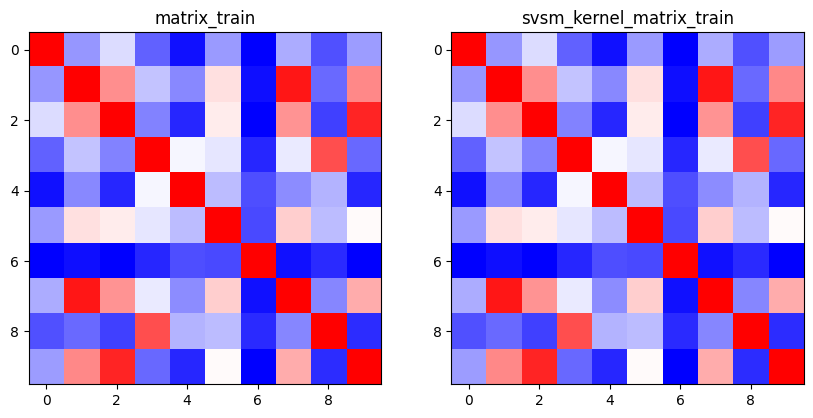

In [48]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(np.asmatrix(matrix_train), interpolation="nearest", origin="upper", cmap="bwr")
axs[0].set_title("matrix_train")
axs[1].imshow(np.asmatrix(svsm_kernel_matrix_train), interpolation="nearest", origin="upper", cmap="bwr")
axs[1].set_title("svsm_kernel_matrix_train")
plt.show()

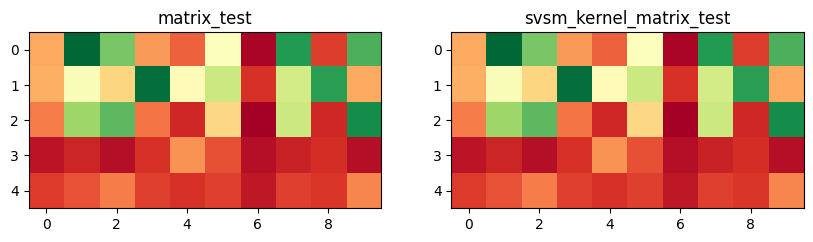

In [49]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(np.asmatrix(matrix_test), interpolation="nearest", origin="upper", cmap="RdYlGn")
axs[0].set_title("matrix_test")
axs[1].imshow(np.asmatrix(svsm_kernel_matrix_test), interpolation="nearest", origin="upper", cmap="RdYlGn")
axs[1].set_title("svsm_kernel_matrix_test")
plt.show()

In [50]:
svc = SVC(kernel="precomputed")
svc.fit(svsm_kernel_matrix_train,Y_train[:nb1])
result1 = svc.score(svsm_kernel_matrix_train,Y_train[:nb1])
result2 = svc.score(svsm_kernel_matrix_test,Y_val[:nb2])
print(result1, result2)

0.9 0.6


---

## tensornetwork simulation

In [51]:
def get_exp(x_t, n_dim, kernel):
    psix = make_bsp(n_dim)
    psiy = psix.inverse()
    circuit = psix.assign_parameters(x_t[0]).compose(psiy.assign_parameters(x_t[0]))
    
    converter = CircuitToEinsum(circuit, backend='numpy')
    a = str(0).zfill(n_dim)
    exp, _ = converter.amplitude(a)  
    return exp
    
def get_operand(circuit,n_dim):
    a = str(0).zfill(n_dim)
    converter = CircuitToEinsum(circuit, backend='numpy')
    _, oper = converter.amplitude(a)  
    return oper    
def all_operands_parallel(circuit, n_dim, num_cpu):
    with Pool(processes=num_cpu, maxtasksperchild=100) as pool:
        indices_list = list(range(len(circuit)))
        operands = pool.starmap(get_operand, [(circuit[i],n_dim) for i in indices_list])
    return operands
def kernel_matrix_tnsm(y_t, x_t, exp, opers, indices_list, options, mode=None):
    kernel_matrix = np.zeros((len(y_t),len(x_t)))
    i, oper = -1, opers[0]
    with Network(exp, *oper, options=options) as tn:
        tn.contract_path()
        for i1, i2 in indices_list:
            i += 1
            tn.reset_operands(*opers[i])     
            amp_tn = abs(tn.contract()) ** 2
            kernel_matrix[i1-1][i2-1] = np.round(amp_tn,8) 
        tn.free()
    if mode == 'train':
        kernel_matrix = kernel_matrix + kernel_matrix.T+np.diag(np.ones((len(x_t))))
    return kernel_matrix

In [52]:
n_dim = 10
data_train, data_val  = data_prepare(n_dim, X_train, X_val)

In [53]:
indices_list_t = list(combinations(range(1, len(data_train) + 1), 2))
indices_list_v = list(product(range(1, len(data_val) + 1),range(1, len(data_train) + 1)))
len(indices_list_t),len(indices_list_v)

(45, 50)

In [54]:
print(len(data_train))
print(len(data_val))

10
5


In [56]:
circuit_train = all_circuits_parallel(data_train, data_train, indices_list_t, n_dim, qkernel, 10)
circuit_val   = all_circuits_parallel(data_val, data_train, indices_list_v, n_dim, qkernel, 10)

TypeError: all_circuits_parallel() takes 5 positional arguments but 6 were given

In [91]:
oper_train = all_operands_parallel(circuit_train, n_dim, 10)
oper_val   = all_operands_parallel(circuit_val,n_dim,10)
len(oper_train),len(oper_val)

(190, 100)

In [94]:
# oper = oper_train[0]
options = NetworkOptions(blocking="auto")
# network = Network(exp, *oper,options=options)
# path, info = network.contract_path()

In [95]:
exp = get_exp(data_train, n_dim, bsp_kernel_tnsm)

tnsm_kernel_matrix_train = kernel_matrix_tnsm(data_train, data_train, exp, oper_train, indices_list_t, options, mode='train')
tnsm_kernel_matrix_test  = kernel_matrix_tnsm(data_val, data_train, exp, oper_val, indices_list_v, options, mode=None)

In [96]:
tnsm_kernel_matrix_train.shape

(20, 20)

In [97]:
(tnsm_kernel_matrix_train-svsm_kernel_matrix_train).max()

0.0

In [98]:
(tnsm_kernel_matrix_test-svsm_kernel_matrix_test).max()

0.0

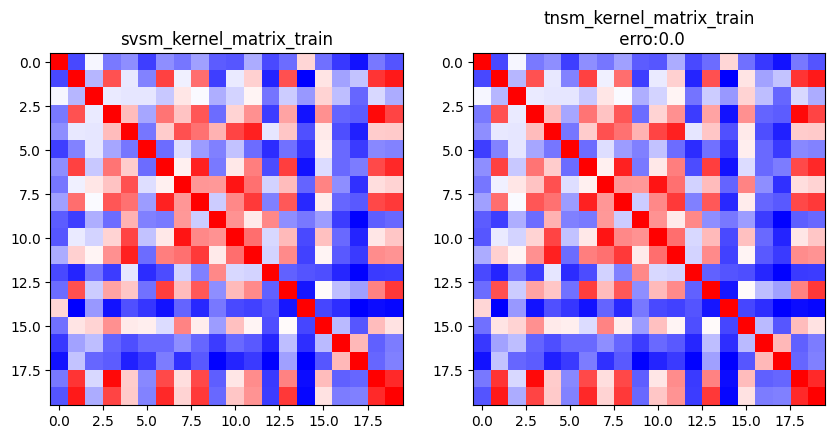

In [99]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(np.asmatrix(svsm_kernel_matrix_train), interpolation="nearest", origin="upper", cmap="bwr")
axs[0].set_title("svsm_kernel_matrix_train")
axs[1].imshow(np.asmatrix(tnsm_kernel_matrix_train), interpolation="nearest", origin="upper", cmap="bwr")
axs[1].set_title(f"tnsm_kernel_matrix_train\n erro:{(tnsm_kernel_matrix_train-svsm_kernel_matrix_train).max()}")
plt.show()